# Statistics review 2: Samples and populations

R code accompanying [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC137296/pdf/cc1473.pdf)

## Key learning points

- A P value is the probability that an observed effect is simply due to chance; it therefore provides a measure of the strength of an association.
- P values are affected both by the magnitude of the effect and by the size of the study from which they are derived, and should therefore be interpreted with caution.
- If the purpose is Descriptive use standard Deviation; if the purpose is Estimation use standard Error

In [1]:
suppressPackageStartupMessages(library(tidyverse))

In [2]:
options(repr.plot.width=4, repr.plot.height=3)

Utility function from http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/

In [3]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

## The Normal distribution

In [4]:
xp <- seq(-3, 3, length.out = 100)
y1 <- dnorm(xp, mean=0, sd=1)
y2 <- dnorm(xp, mean=0, sd=0.5)
y3 <- dnorm(xp, mean=0, sd=1.5)
df1 <- data.frame(x=xp, y1=y1, y2=y2, y3=y3)

### Standard normal

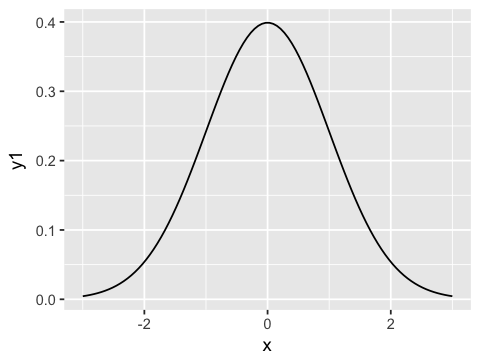

In [5]:
ggplot(df1, aes(x=x, y=y1)) + geom_line()

### Small and large standard deviations

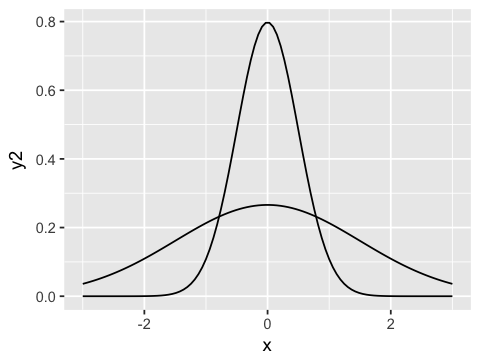

In [6]:
ggplot(df1, aes(x=x, y=y2)) + geom_line() + geom_line(aes(y=y3))

### Normally distributed data

In [7]:
hb <- rnorm(2849, mean=10, sd=2.5)
df2 <- data.frame(hb = hb)

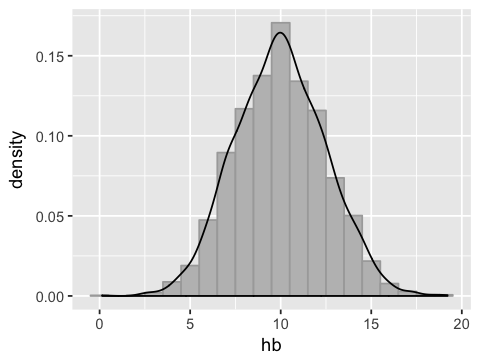

In [8]:
ggplot(df2, aes(x=hb)) + 
geom_histogram(binwidth=1, fill='grey', color='darkgrey', aes(y=..density..)) + 
geom_density()

### What is the range of hb values that contains 95% of the mass?

In [9]:
mu = mean(df2$hb)
sigma = sd(df2$hb)

In [10]:
round(c(mu - 1.96 * sigma, mu + 1.96 * sigma), 2)

[1]  5.11 14.85

#### Converting to standard normal

In [11]:
df2$z <- (df2$hb - mu)/sigma

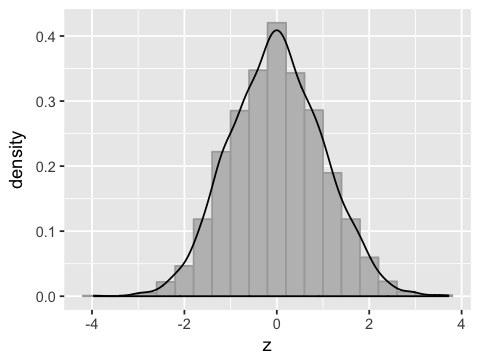

In [12]:
ggplot(df2, aes(x=z)) + 
geom_histogram(binwidth=0.4, fill='grey', color='darkgrey', aes(y=..density..)) + 
geom_density()

## Area under normal curve

#### 95% area lies within -1.96 and 1.06

In [13]:
plot_area <- function(lower, upper) {
    x <- seq(-3,3,length.out = 100)
    y <- dnorm(x, 0, 1)
    df <- data.frame(x=x, y=y)
    area <- round(100 * pnorm(upper) - pnorm(lower), 2)
    ggplot(df, aes(x=x, y=y)) + geom_line() +
    stat_function(fun = dnorm, 
                  xlim = c(lower, upper),
                  geom = "area",
                  fill='salmon') +
    scale_x_continuous(breaks=c(lower, upper)) +
    annotate("text", label = paste(area, "%", sep=""), size=3, x = 2, y = 0.3) +
    xlab("") + ylab("") +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank())
    }

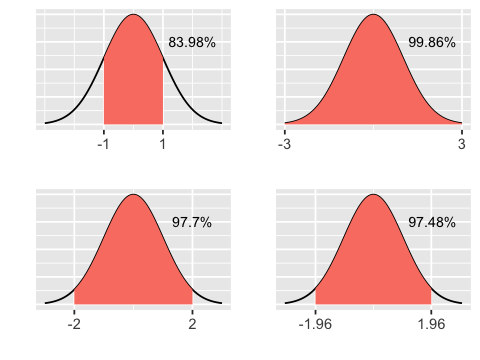

In [14]:
g1 <- plot_area(-1, 1)
g2 <- plot_area(-2, 2)
g3 <- plot_area(-3, 3)
g4 <- plot_area(-1.96, 1.96)
multiplot(g1, g2, g3, g4, cols = 2)

## From sample to population

In [15]:
n.samples <- 100
n.reps <- 1000
x <- replicate(n.reps,runif(n.samples))

#### A singel sample is not normally distributed

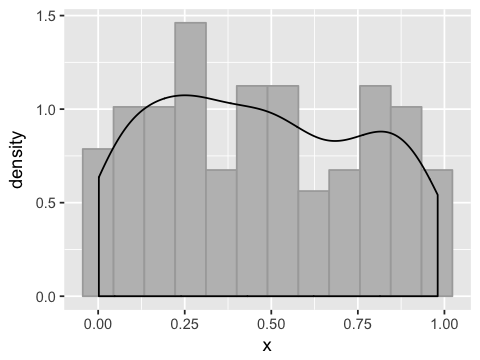

In [16]:
df3 <- data.frame(x=x[,1])
ggplot(df3, aes(x=x)) + 
geom_histogram(bins=12, fill='grey', color='darkgrey', aes(y=..density..)) + 
geom_density()

#### But the means of the samples is approximately normally distributed

This is a consequence of the Central Limit Theorem -  sums of independent random variables are normally distributed. 

In [17]:
mus <- apply(x, 2, mean)
df4 <- data.frame(mus=mus)

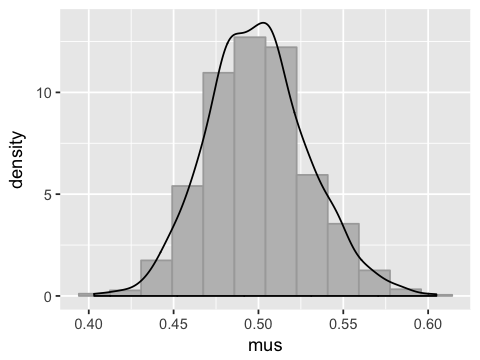

In [18]:
ggplot(df4, aes(x=mus)) + 
geom_histogram(bins=12, fill='grey', color='darkgrey', aes(y=..density..)) + 
geom_density()

####  Standard Error (SE)

The standard deviation of the means (or standard error) is the sample standard deviation divided by the square root of the number of samples

In [19]:
round(sd(mus), 3)

[1] 0.03

In [20]:
round(sd(x[,1])/sqrt(length(x[,1])), 3)

[1] 0.03

## The standard error and confidence interval

### Plot showing two 95% confidence intervals and the true population mean

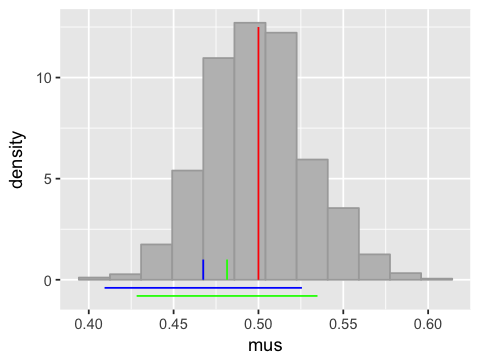

In [21]:
# Standardize the sample means 
z <- (mus - mean(mus))/sd(mus)

# Find 95% confidence intervals of two sample means
x1.lo <- mean(x[,1]) - 1.96*sd(x[,1])/sqrt(n.samples)
x1.hi <- mean(x[,1]) + 1.96*sd(x[,1])/sqrt(n.samples)

x2.lo <- mean(x[,2]) - 1.96*sd(x[,2])/sqrt(n.samples)
x2.hi <- mean(x[,2]) + 1.96*sd(x[,2])/sqrt(n.samples)

# 95% of the mass lies within +/- 1.96 of the SE
ggplot(df4, aes(x=mus)) + 
geom_histogram(bins=12, fill='grey', color='darkgrey', aes(y=..density..)) + 
annotate("segment", x = x1.lo, xend = x1.hi, y = -0.4, yend = -0.4, colour = "blue") +
annotate("segment", x = x2.lo, xend = x2.hi, y = -0.8, yend = -0.8, colour = "green") +
annotate("segment", x = mean(x[,1]), xend = mean(x[,1]), y = 0, yend = 1, colour = "blue") +
annotate("segment", x = mean(x[,2]), xend = mean(x[,2]), y = 0, yend = 1, colour = "green") +
annotate("segment", x = 0.5, xend = 0.5, y = 0, yend = 12.5, colour = "red") 

##  Confidence intervals for smaller samples

In [22]:
x <- seq(-3, 3, length.out = 100)
y1 <- dnorm(x)
y2 <- dt(x, df=4)
y3 <- dt(x, df=19)

df5 <- data.frame(x=x, normal=y1, t4=y2, t19=y3)

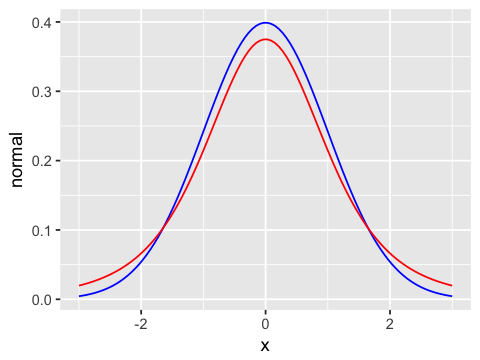

In [23]:
ggplot(df5, aes(x=x, y=normal)) + 
geom_line(color='blue') + # normal
geom_line(aes(y=t4), color='red') # T with 4 degrees of freedom

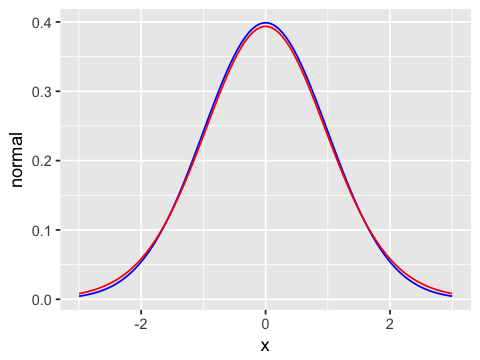

In [24]:
ggplot(df5, aes(x=x, y=normal)) + 
geom_line(color='blue') + # normal
geom_line(aes(y=t19), color='red') # T with 19 degrees of freedom

### Scaling factors for confidence interval with diffent sample sizes

In [25]:
dfs <- c(10, 20, 30, 40, 50, 200)
k <- round(qt(0.975, df=dfs), 2)
df6 <- data.frame(n=dfs, k=k)
df6

n,k
10,2.23
20,2.09
30,2.04
40,2.02
50,2.01
200,1.97


## Exercises

**1**. Load the file `data/data.csv` into a data frame. Make a histogram of the column `x` data.

**2**. Calculate the mean and 90% reference range of `x`.

**3**. Calculate the standard error and 90% confidence intervals for the estimated mean of `x`.

**4**. Write a function that takes a collection of numbers as input and returns the standard error.